# Segment Anything for Fast Developing Embryos
Cellular shape dynamics are critical for understanding cell fate determination and organogenesis during development. However, fluorescence live-cell images of cell membranes frequently suffer from a low signal-to-noise ratio, especially during long-duration imaging with high spatiotemporal resolutions. This is caused by phototoxicity and photobleaching, which limit laser power and hinder effective time-lapse cell shape reconstruction, particularly in rapidly developing embryos. Here, we devised a new computational framework, EmbSAM, that incorporates a deep-learning-based cell boundary localization algorithm and the Segment Anything Model. EmbSAM enables accurate and robust three-dimensional cell membrane segmentation for roundworm Caenorhabditis elegans embryos imaged every 10 seconds. The cell shape data prior to gastrulation quantitatively characterizes a series of cell-division-coupled morphodynamics associated with cell position, cell identity, lineage, and fate.


## Overview

1. Load the configuration file
2. Denoising
3. Bounding box prompt generator
4. Run SAM inference





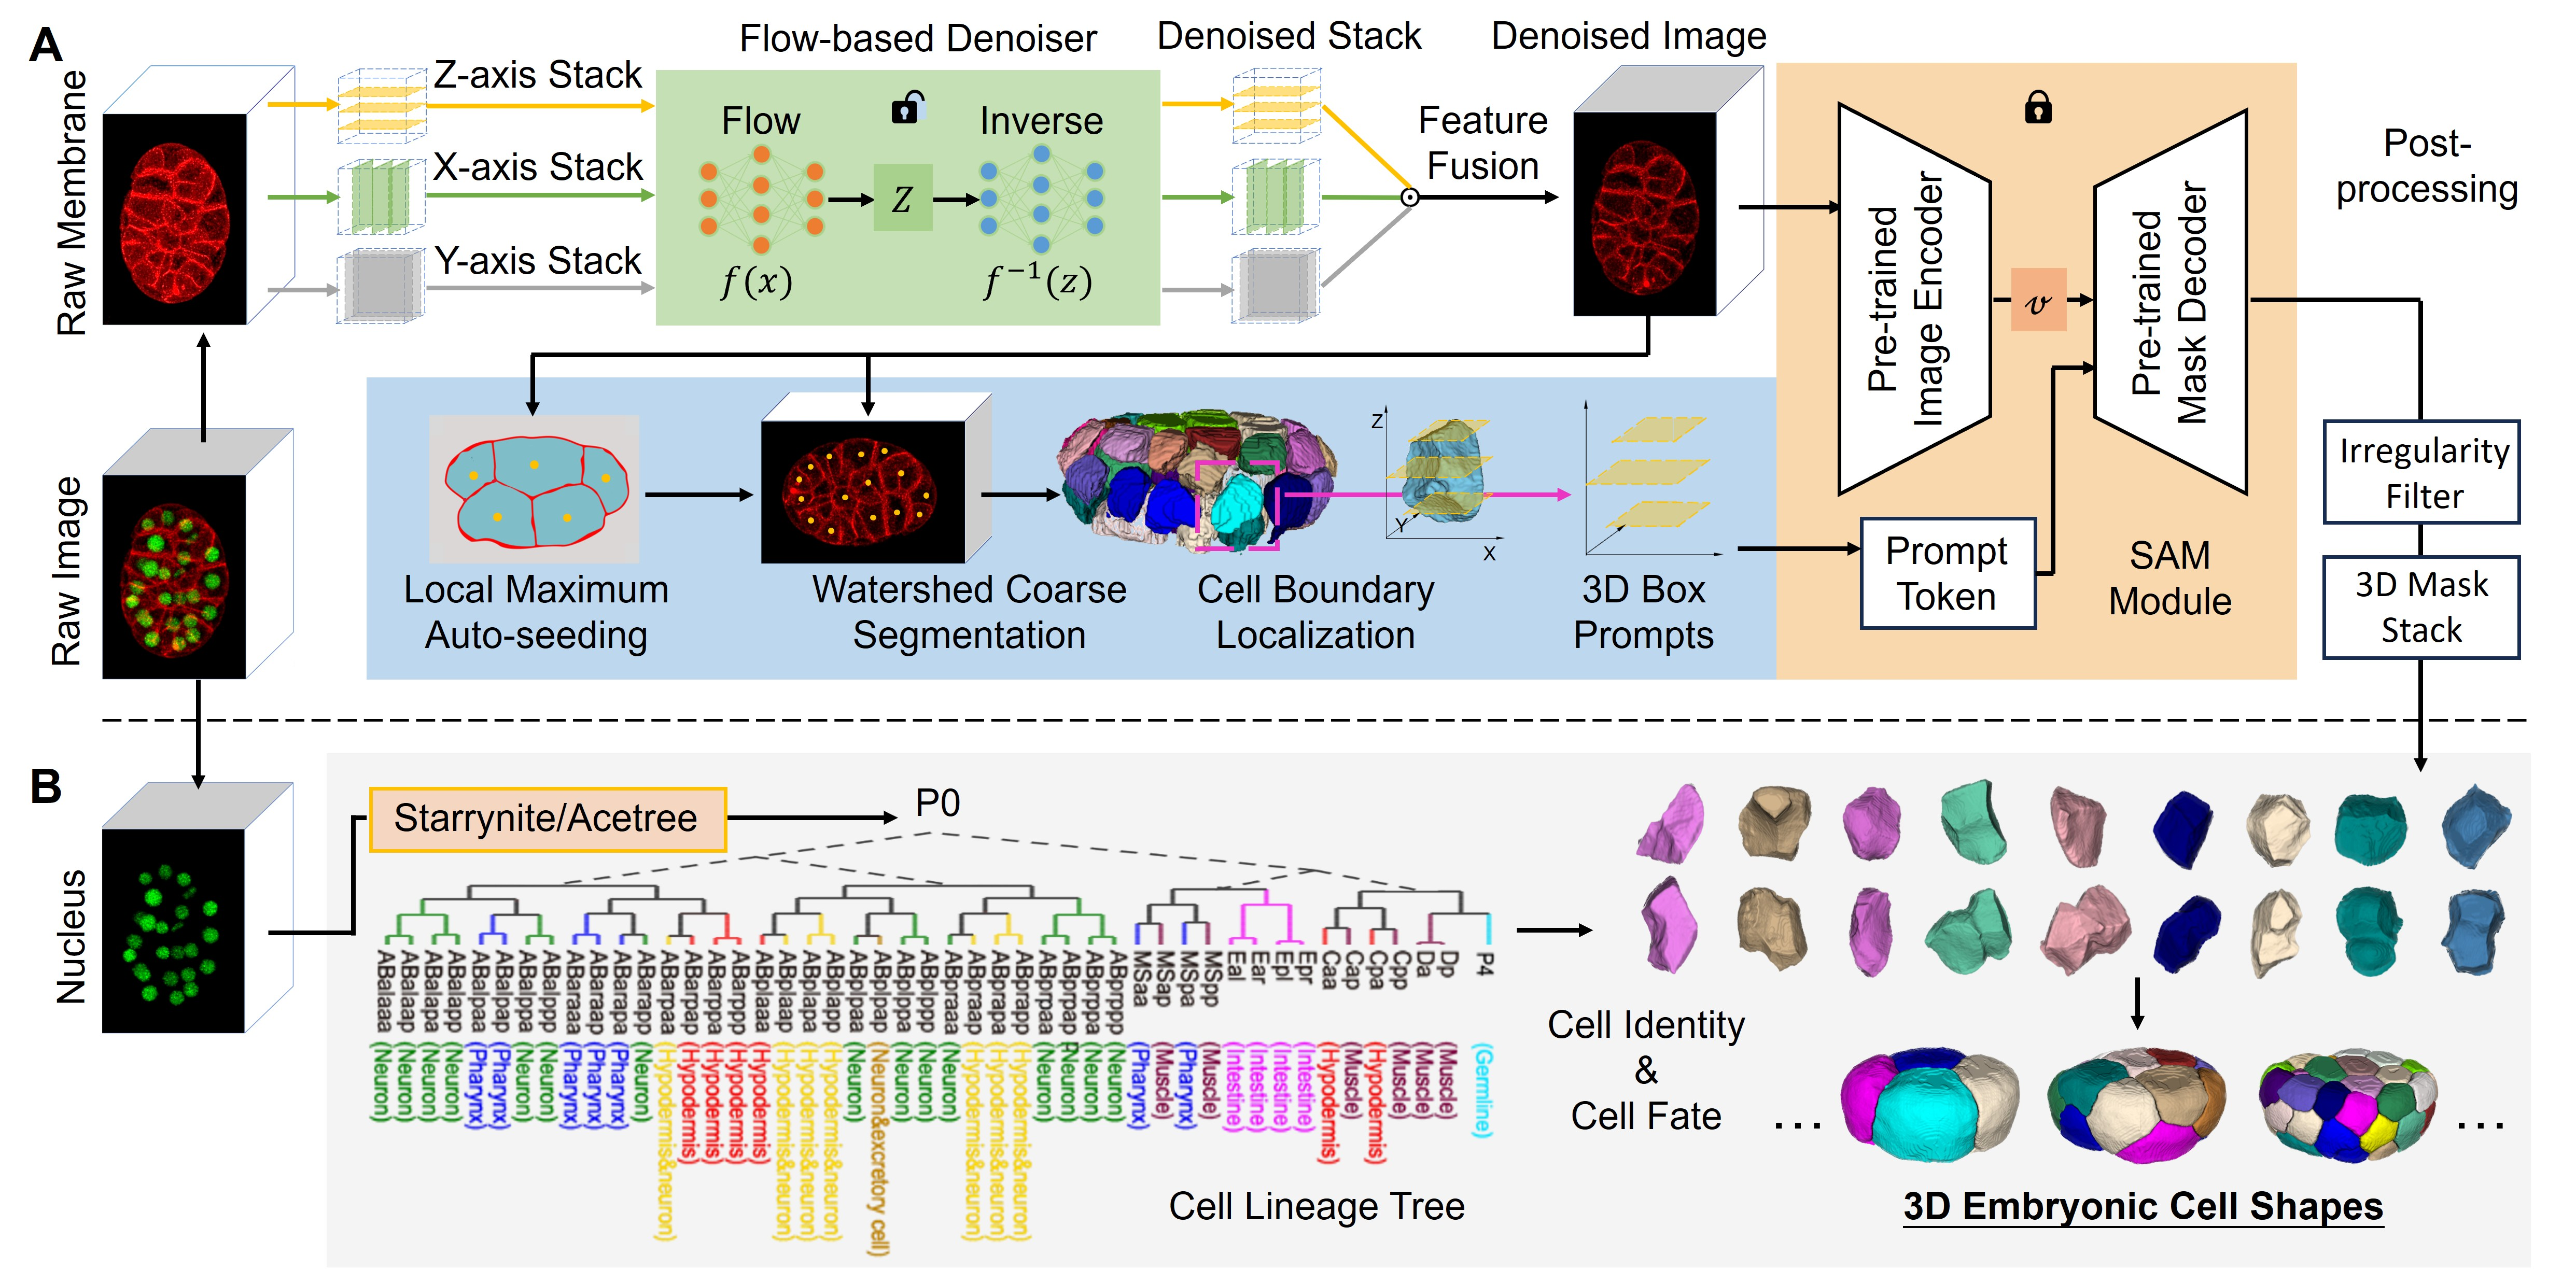

In [2]:
from figures_readme.display_image import display_image
display_image("./figures_readme/fig1.jpg", width=700)

The proposed computational framework for cell segmentation, EmbSAM, consists of three major parts 
- The cell boundary localization part for denoising fluorescence images and generating bounding box prompts for each cell region. This is primarily composed of a denoising module (the deep neural network that removes small noisy components to increase the SNR of raw images) and a bounding box prompt generator (the coarse segmentation for approximate boundaries of the target cell to generate precise bounding box prompts).
- The Segment Anything Model (SAM) part for final automatic cell segmentation. This accomplishes automatic cell segmentation based on a series of bounding box promoters. The SAM module maximizes the performance of the proposed framework, whose pre-trained model was trained with billions of images containing thousands of imaging conditions. It is one of the reasons that it probably can help deal with low-SNR images. For the target cells in each slice (focal plane), the bounding box produced by the cell boundary location part was used to facilitate the SAM segmentation with 3D assembling.
- The cell tracing part for assigning cell identity to the reconstructed 3D cell regions. The cell nucleus location output by StarryNite and AceTree is used to match its corresponding 3D cell region.

## 1: Load the configuration file
The model_parameters with Segment Anything Model(vit_b) and the image denosing module trained on X_axis, Y_axis and Z_axis [[model_parameters](https://drive.google.com/drive/folders/1vNp7KypEOxTXCxHLS6N4kET1M_cfBtup?usp=drive_link)]. You can download these parameters and put them into model_parameters.
* **Structure of model_parameters**: 
    ```buildoutcfg
    model_parameters/
      |--Z_axis.pth
      |--Y_axis.pth
      |--X_axis.pth
      |--sam_vit_b_01ec64.pth
    ```

In [1]:
import warnings
warnings.filterwarnings("ignore")
from EmbSAM import *
config_file = './confs/running_Emb1.txt'
nii_path = './nii/'
opdir = './output/'
params = init_config(config_file, nii_path, opdir)

nii_path: ./nii/
opdir: ./output/
rootname: Emb1_
CD_file: ./confs/Emb1_CellTracing.csv
time_point: [30]
ori_shape: (512, 712, 68)
raw_path: ./data/Emb1_raw
data_shape: (256, 356, 160)
scale: 255.0


## 2: Denoise


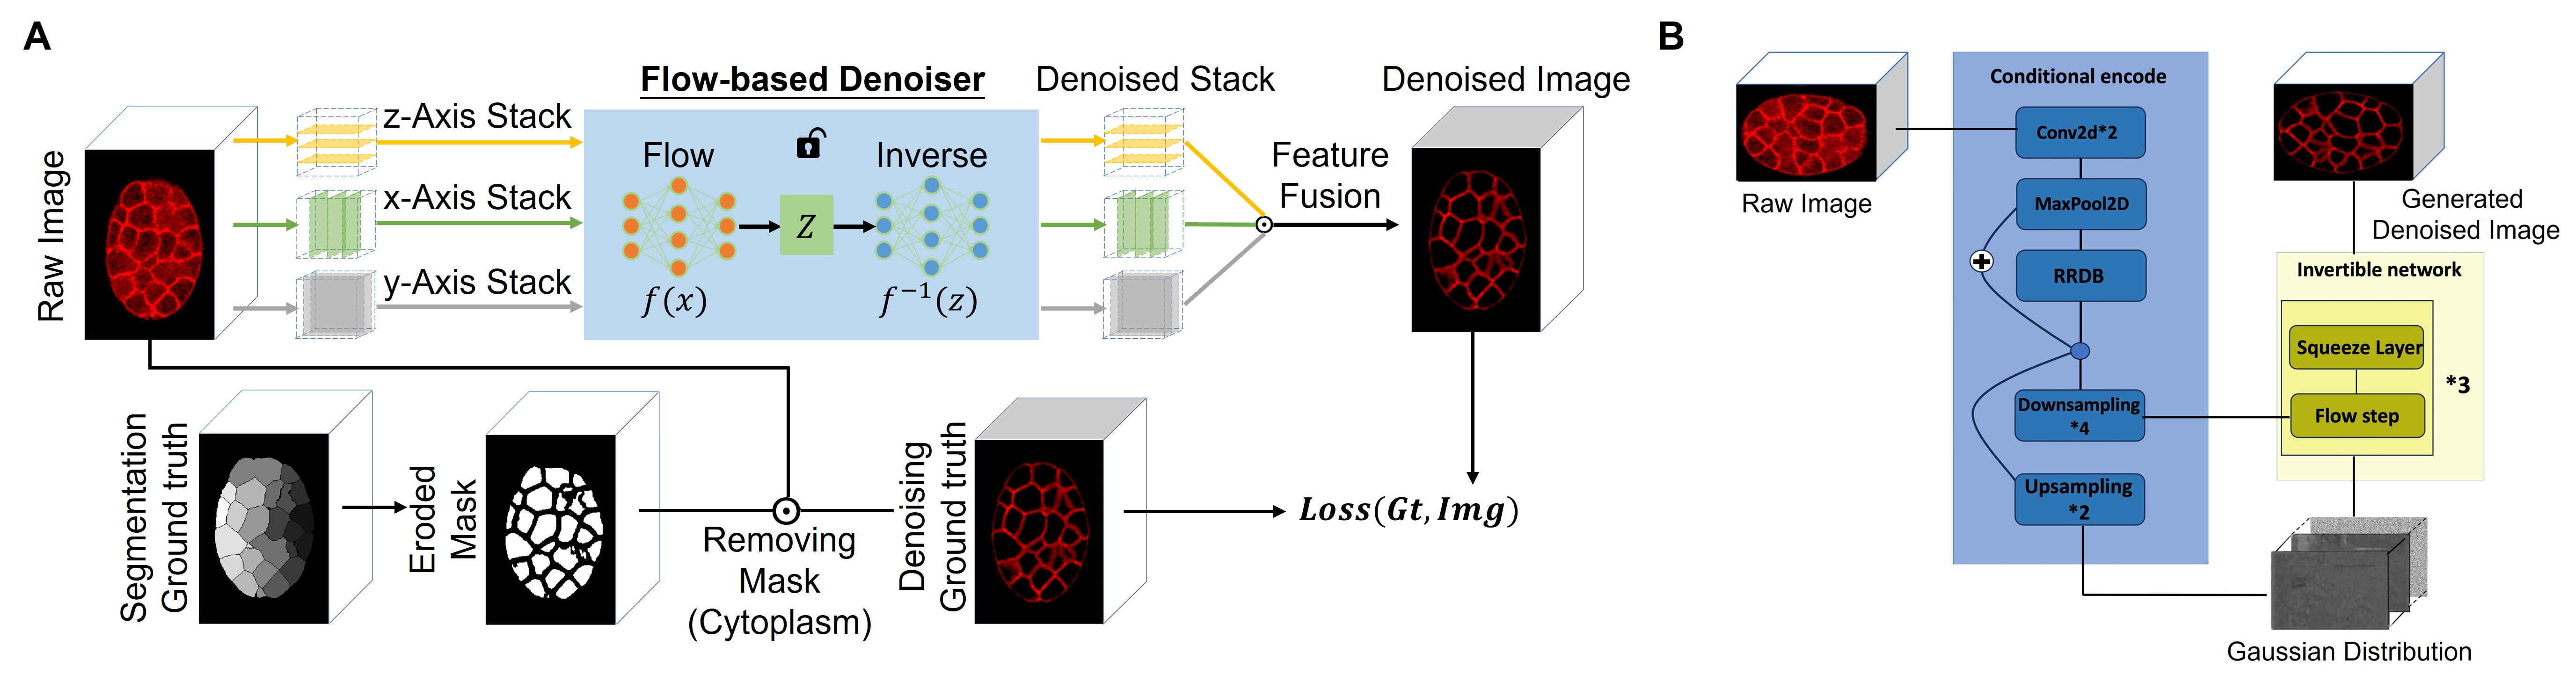

In [10]:
from figures_readme.display_image import display_image
display_image("./figures_readme/fig2.jpg", width=800)

./nii/Emb1_030.nii.gz
File: Emb1_030.nii.gz - Shape: (256, 356, 160)
processing...
-------------------------denoising-------------------------
OrderedDict([('manual_seed', 10), ('lr_G', 0.0004), ('weight_decay_G', 0), ('beta1', 0.9), ('beta2', 0.99), ('lr_scheme', 'MultiStepLR'), ('warmup_iter', -1), ('lr_steps_rel', [0.15, 0.3, 0.45, 0.6]), ('lr_gamma', 0.5), ('weight_l1', 0), ('weight_fl', 1), ('niter', 10000), ('val_freq', 100), ('lr_steps', [1500, 3000, 4500, 6000])])


256it [00:13, 18.58it/s]


OrderedDict([('manual_seed', 10), ('lr_G', 0.0004), ('weight_decay_G', 0), ('beta1', 0.9), ('beta2', 0.99), ('lr_scheme', 'MultiStepLR'), ('warmup_iter', -1), ('lr_steps_rel', [0.15, 0.3, 0.45, 0.6]), ('lr_gamma', 0.5), ('weight_l1', 0), ('weight_fl', 1), ('niter', 10000), ('val_freq', 100), ('lr_steps', [1500, 3000, 4500, 6000])])


356it [00:21, 16.54it/s]
0it [00:00, ?it/s]

OrderedDict([('manual_seed', 10), ('lr_G', 0.0004), ('weight_decay_G', 0), ('beta1', 0.9), ('beta2', 0.99), ('lr_scheme', 'MultiStepLR'), ('warmup_iter', -1), ('lr_steps_rel', [0.15, 0.3, 0.45, 0.6]), ('lr_gamma', 0.5), ('weight_l1', 0), ('weight_fl', 1), ('niter', 10000), ('val_freq', 100), ('lr_steps', [1500, 3000, 4500, 6000])])


160it [00:10, 15.71it/s]


(356, 160, 256)
(256, 356, 160)
Transposed NIfTI image saved and original file overwritten at: ./output/Emb1_030_X.nii.gz
Done
(256, 160, 356)
(256, 356, 160)
Transposed NIfTI image saved and original file overwritten at: ./output/Emb1_030_Y.nii.gz
Done
(256, 356, 160)
(256, 356, 160)
Transposed NIfTI image saved and original file overwritten at: ./output/Emb1_030_Z.nii.gz
Done
Fused image saved at: ./output/Emb1_030.nii.gz
Deleted ./output/Emb1_030_X.nii.gz
Deleted ./output/Emb1_030_Y.nii.gz
Deleted ./output/Emb1_030_Z.nii.gz


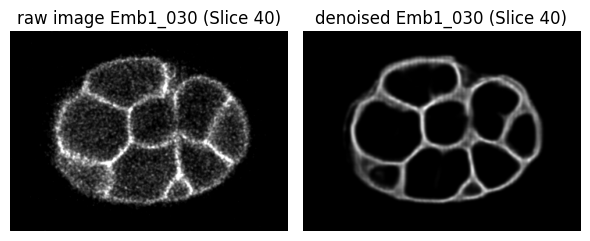

In [2]:
denoise_pipeline(params['raw_path'], params['nii_path'], params['rootname'], params['data_shape'], 
                 params['time_point'], params['scale'], params['output_X'], params['output_Y'], 
                 params['output_Z'], params['opdir'], params['result_X'], params['result_Y'], params['result_Z'],
                 params['size_X'], params['size_Y'], params['size_Z'],display=True)

## 3: Bounding box prompt generator


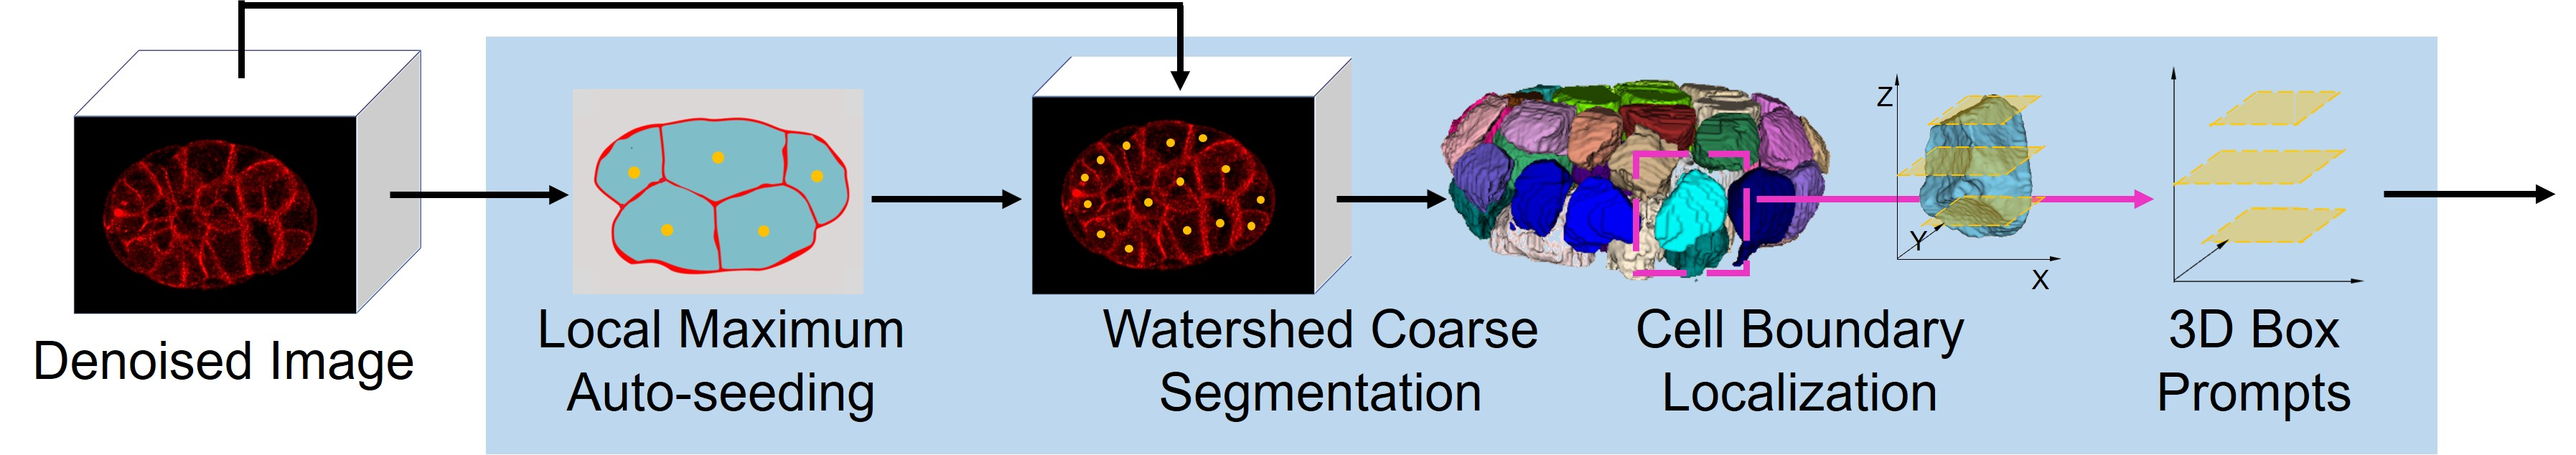

In [11]:
from figures_readme.display_image import display_image
display_image("./figures_readme/fig4.jpg", width=800)

processing Emb1_030.nii.gz...


toseg membrane --> cell, all cpu process is 32, we created 1:   0%|                              | 0/1 [00:00<?, ?it/s]

-------------------------watershed coarse seg-------------------------


toseg membrane --> cell, all cpu process is 32, we created 1: 100%|██████████████████████| 1/1 [00:23<00:00, 23.11s/it]


done
-----------------------bounding box prompts-----------------------


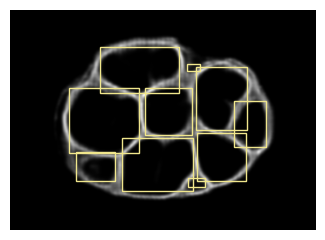

In [3]:
boundary_localization_pipeline(params['opdir'], params['rootname'], params['time_point'], 
                               params['CD_file'], params['ratio'], params['ori_shape'])

## 4: SAM inference


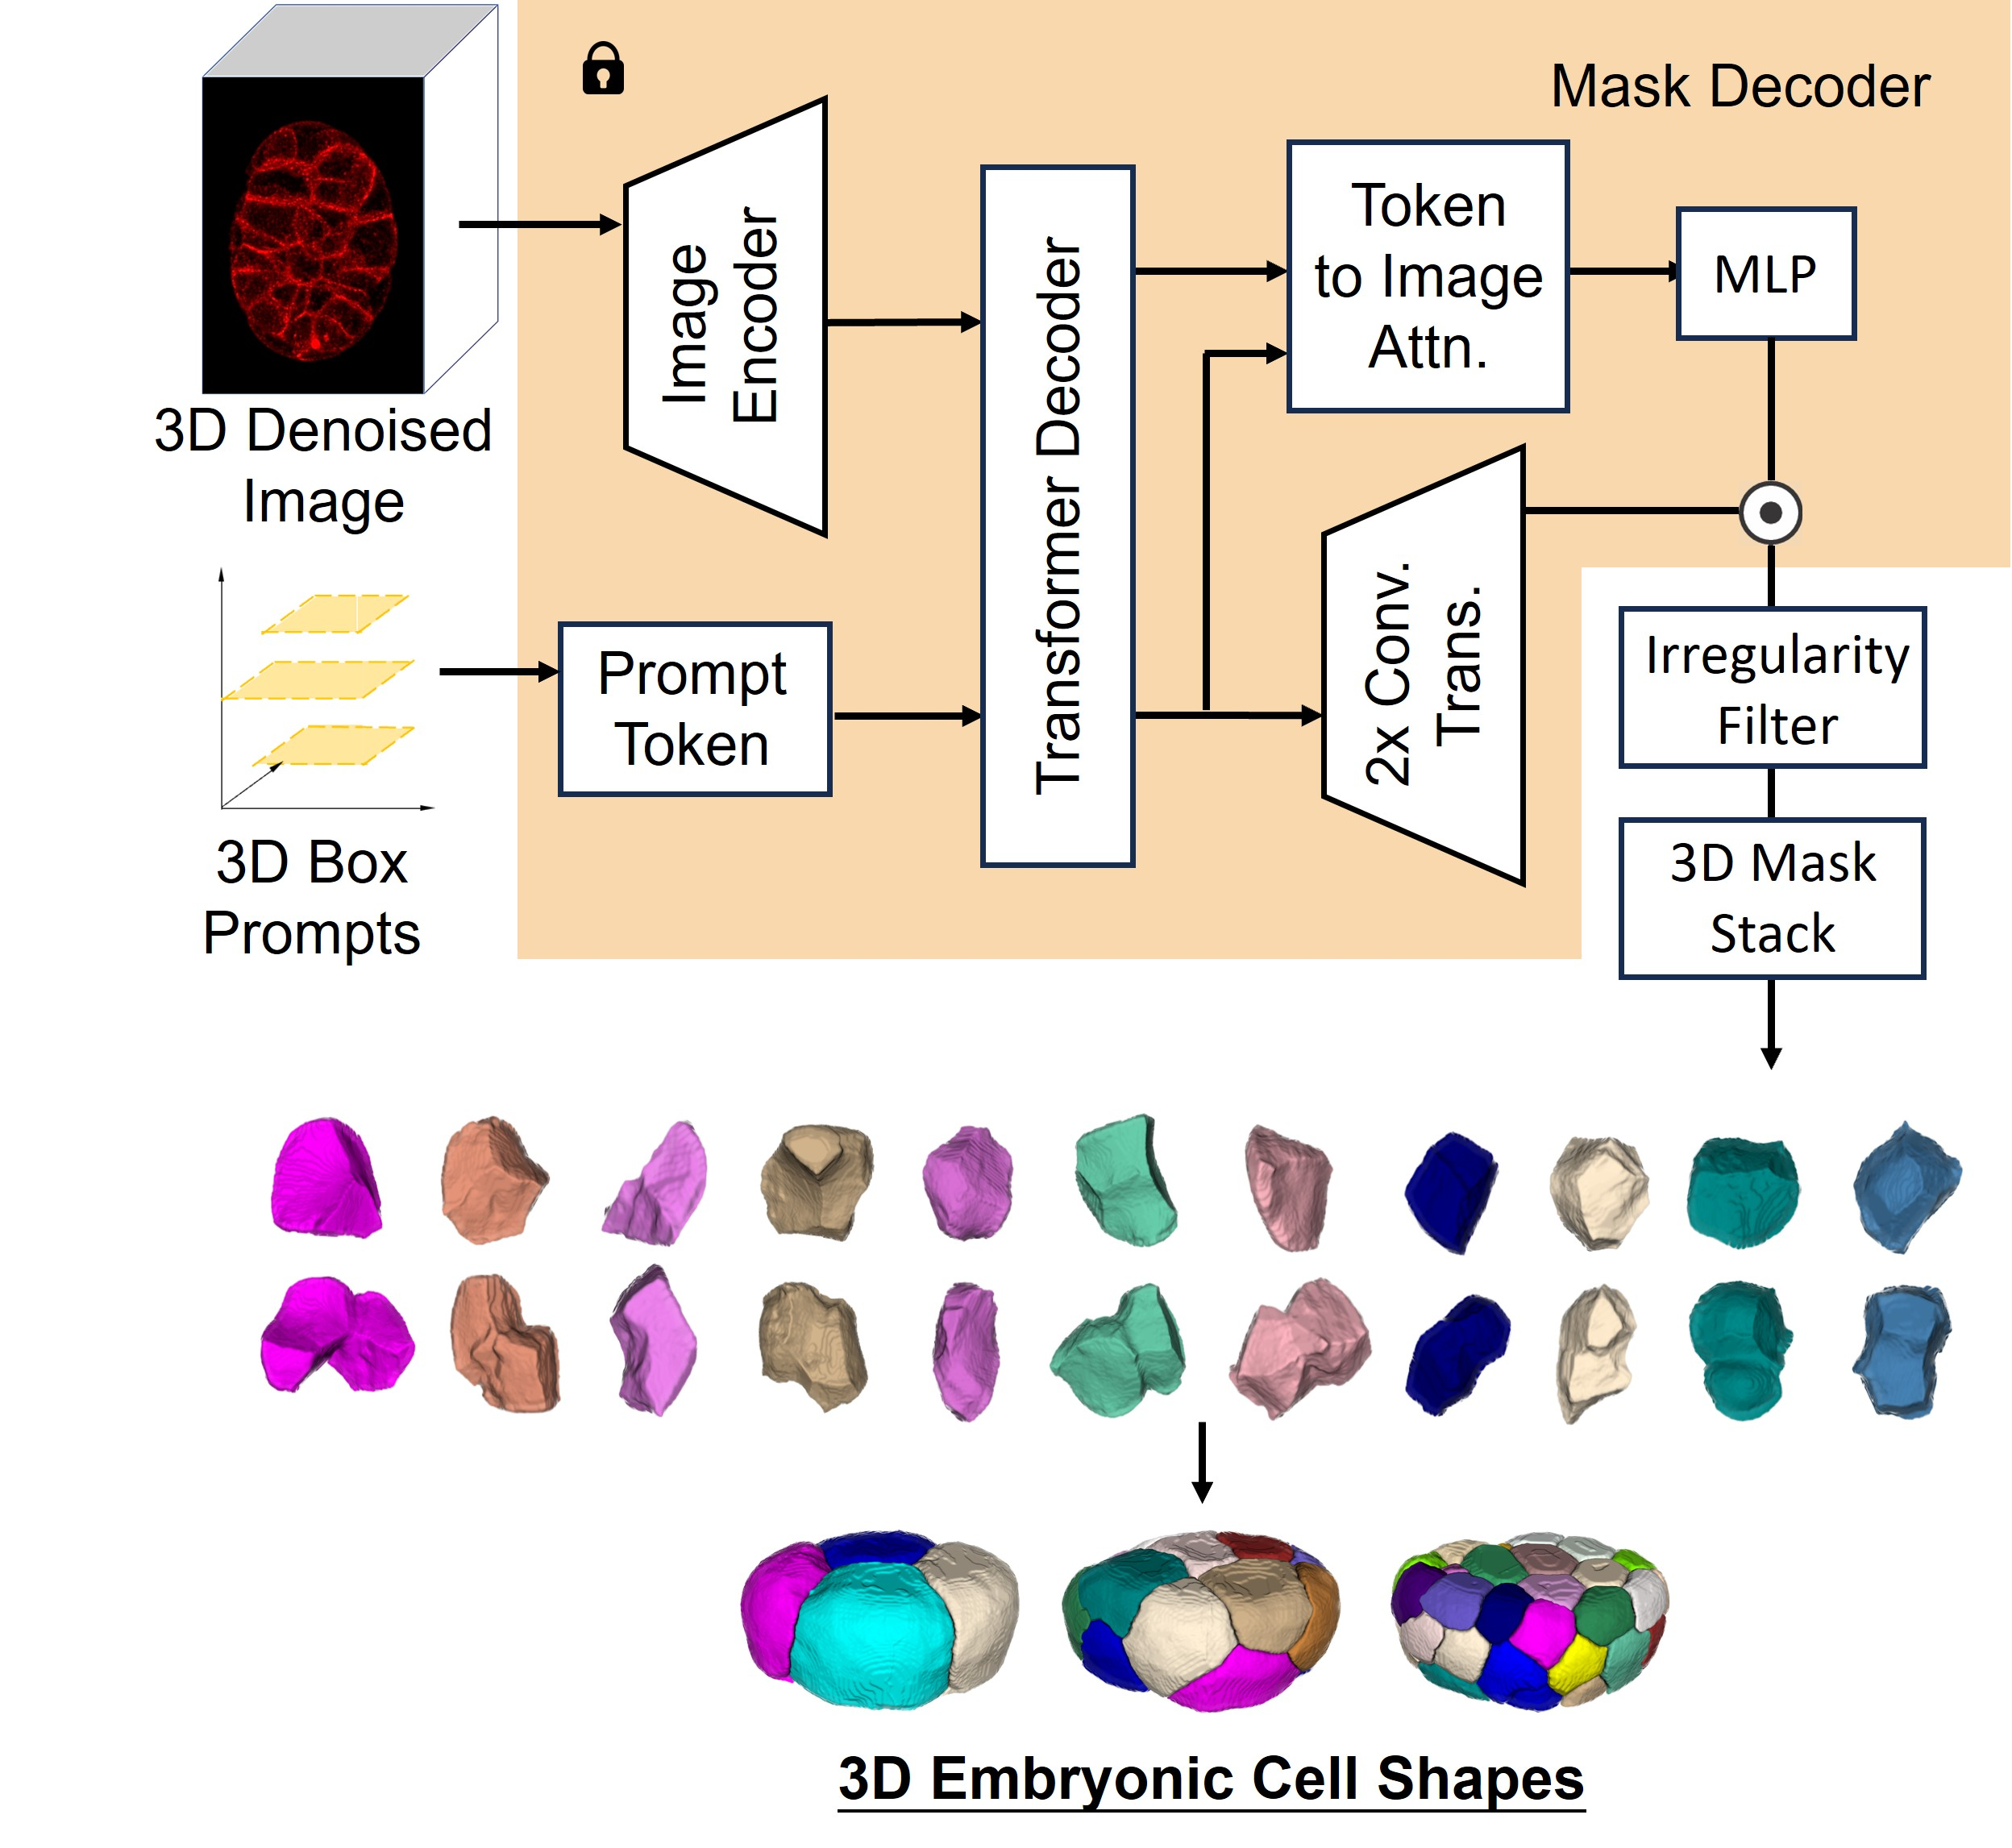

In [9]:
from figures_readme.display_image import display_image
display_image("./figures_readme/fig3.jpg", width=400)

In [4]:
sam_checkpoint = "./model_parameters/sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda"
predictor=load_model(sam_checkpoint, model_type, device)
segment_anything(params['opdir'], params['data_shape'], params['raw_path'], params['rootname'], predictor)

Processing subfolder: ./output/matrix/Emb1_030
./output/matrix/Emb1_030\Emb1_030_ABala.nii.gz done
./output/matrix/Emb1_030\Emb1_030_ABalp.nii.gz done
./output/matrix/Emb1_030\Emb1_030_ABara.nii.gz done
./output/matrix/Emb1_030\Emb1_030_ABarp.nii.gz done
./output/matrix/Emb1_030\Emb1_030_ABpla.nii.gz done
./output/matrix/Emb1_030\Emb1_030_ABplp.nii.gz done
./output/matrix/Emb1_030\Emb1_030_ABpra.nii.gz done
./output/matrix/Emb1_030\Emb1_030_ABprp.nii.gz done
./output/matrix/Emb1_030\Emb1_030_Ca.nii.gz done
./output/matrix/Emb1_030\Emb1_030_Cp.nii.gz done
./output/matrix/Emb1_030\Emb1_030_Ea.nii.gz done
./output/matrix/Emb1_030\Emb1_030_Ep.nii.gz done
./output/matrix/Emb1_030\Emb1_030_MSa.nii.gz done
./output/matrix/Emb1_030\Emb1_030_MSp.nii.gz done
./output/matrix/Emb1_030\Emb1_030_P3.nii.gz done
done


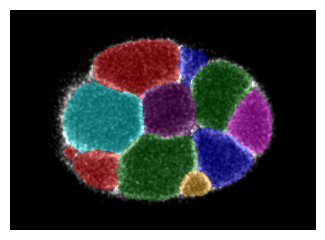

All tasks have been completed successfully!
Please check the Unprocessed 3D image volume at ./nii/
and the segmentation results in ./output/result.
Thank you!


In [6]:
Visualization(nii_path, params['opdir'], params['rootname'], params['time_point'])
print(f"All tasks have been completed successfully!\nPlease check the Unprocessed 3D image volume at {nii_path}\nand the segmentation results in {params['opdir']}result.\nThank you!")

# 3d Visualization
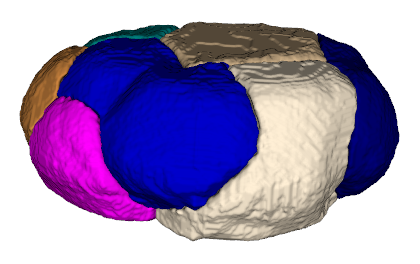